In [10]:
qasm_str = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[3];
cx q[0],q[1];
cx q[1],q[0];
cx q[0],q[1];
u3(0,3*pi/4,3*pi/4) q[2];
"""

In [11]:
from pytket.passes import KAKDecomposition
from copy import deepcopy
from pytket.passes import FullPeepholeOptimise
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.qasm import circuit_from_qasm_str, circuit_to_qasm_str

tket_circuit = circuit_from_qasm_str(qasm_str)
qc = tk_to_qiskit(tket_circuit)
print(qc.draw())


optimization_pass = KAKDecomposition()

print("Applying Kak decomposition")
optimization_pass.apply(tket_circuit)

print("Optimized circuit:")
qc_opt = tk_to_qiskit(tket_circuit)
print(qc_opt.draw())

new_qasm_str = circuit_to_qasm_str(tket_circuit)
print(new_qasm_str)

                       ┌───┐     
q_0: ────────■─────────┤ X ├──■──
           ┌─┴─┐       └─┬─┘┌─┴─┐
q_1: ──────┤ X ├─────────■──┤ X ├
     ┌─────┴───┴──────┐     └───┘
q_2: ┤ U(0,3π/4,3π/4) ├──────────
     └────────────────┘          
c: 3/════════════════════════════
                                 
Applying Kak decomposition
Optimized circuit:
                             
q_0: ────────────────────────
                             
q_1: ────────────────────────
     ┌──────────────────────┐
q_2: ┤ U(0,-π/2,π/2 + 3π/2) ├
     └──────────────────────┘
c: 3/════════════════════════
                             
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];
creg c[3];
u3(0.0*pi,-0.5*pi,2.0*pi) q[2];



In [12]:
from mqt import qcec
result = qcec.verify(
    qc,
    qc_opt,
    transform_dynamic_circuit=True)


def compare_unitary(qc1, qc2) -> bool:
    # remove the measure gates
    qc1 = qc1.copy()
    qc2 = qc2.copy()
    qc1.data = [gate for gate in qc1.data if gate[0].name != 'measure']
    qc2.data = [gate for gate in qc2.data if gate[0].name != 'measure']
    print(qc1.draw())
    print(qc2.draw())

    # compare the unitary matrices
    from qiskit.quantum_info import Operator
    u1 = Operator(qc1).data
    u2 = Operator(qc2).data
    from numpy import allclose
    circuits_are_equivalent = allclose(u1, u2)
    if not circuits_are_equivalent:
        print("unitary matrices are not equivalent")
        print(u1)
        print(u2)
    return circuits_are_equivalent


unitary_equivalence = compare_unitary(qc, qc_opt)
print("unitary_equivalence:")
print(unitary_equivalence)


equivalence = str(result.equivalence)
print("equivalence:")
print(equivalence)

                       ┌───┐     
q_0: ────────■─────────┤ X ├──■──
           ┌─┴─┐       └─┬─┘┌─┴─┐
q_1: ──────┤ X ├─────────■──┤ X ├
     ┌─────┴───┴──────┐     └───┘
q_2: ┤ U(0,3π/4,3π/4) ├──────────
     └────────────────┘          
c: 3/════════════════════════════
                                 
                             
q_0: ────────────────────────
                             
q_1: ────────────────────────
     ┌──────────────────────┐
q_2: ┤ U(0,-π/2,π/2 + 3π/2) ├
     └──────────────────────┘
c: 3/════════════════════════
                             
unitary matrices are not equivalent
[[ 1.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j
   0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  1.0000000e+00+0.j
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j
   0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  1.0000000e+00+0.j  0.0000000e+00+0.j
   0.000000

/tmp/ipykernel_526021/146943001.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  qc1.data = [gate for gate in qc1.data if gate[0].name != 'measure']
/tmp/ipykernel_526021/146943001.py:13: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  qc2.data = [gate for gate in qc2.data if gate[0].name != 'measure']


Matrix dimensions: (8, 8)


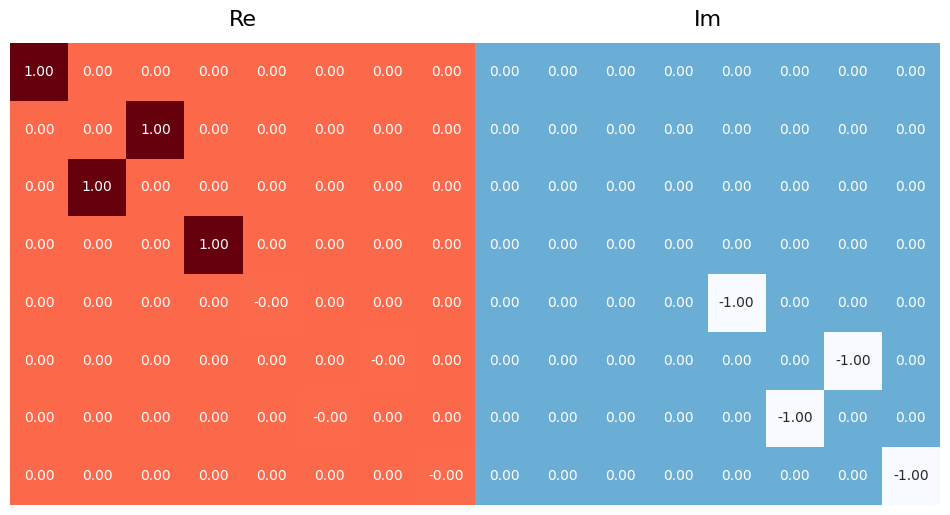

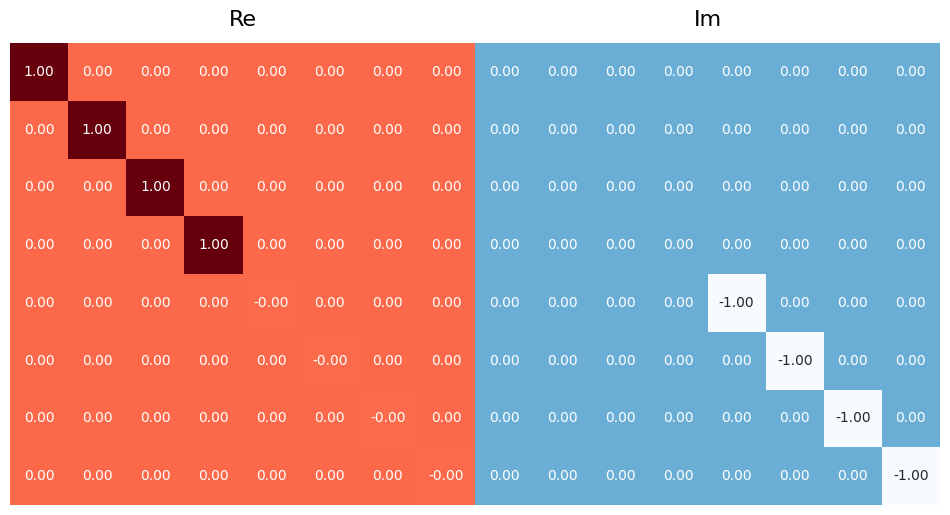

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit.quantum_info import Operator

op_start = Operator(qc)
op_optimized = Operator(qc_opt)
print("Matrix dimensions:", op_start.data.shape)


def split_real_imag(matrix):
    return matrix.real, matrix.imag


real_start, imag_start = split_real_imag(op_start.data)
real_optimized, imag_optimized = split_real_imag(op_optimized.data)


def zoom_in_matrix(matrix, perc_zoom):
    n = matrix.shape[0]
    zoom = int(n * perc_zoom)
    return matrix[n//2 - zoom:n//2 + zoom, n//2 - zoom:n//2 + zoom]


# ZOOM = 1
# print("Warning: zooming in the matrix by a factor of", ZOOM)
# real_start = zoom_in_matrix(real_start, ZOOM)
# imag_start = zoom_in_matrix(imag_start, ZOOM)
# real_optimized = zoom_in_matrix(real_optimized, ZOOM)
# imag_optimized = zoom_in_matrix(imag_optimized, ZOOM)


def plot_combined_heatmaps(real_matrix, imag_matrix, filename):
    combined_matrix = np.hstack((real_matrix, imag_matrix))
    fig, ax = plt.subplots(figsize=(12, 6))
    vmin, vmax = -1, 1

    # Create a mask to apply different color maps
    mask = np.zeros_like(combined_matrix, dtype=bool)
    mask[:, :real_matrix.shape[1]] = True  # Left half (real part)

    # Plot the heatmap with different color maps
    sns.heatmap(combined_matrix, annot=True, fmt=".2f", cmap='Reds',
                cbar=False, ax=ax, vmin=vmin, vmax=vmax, mask=~mask)
    sns.heatmap(combined_matrix, annot=True, fmt=".2f", cmap='Blues',
                cbar=False, ax=ax, vmin=vmin, vmax=vmax, mask=mask)

    # Add titles
    ax.text(0.25, 1.05, 'Re', ha='center', va='center',
            transform=ax.transAxes, fontsize=16)
    ax.text(0.75, 1.05, 'Im', ha='center',
            va='center', transform=ax.transAxes, fontsize=16)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.savefig(filename, bbox_inches='tight')
    plt.show()


plot_combined_heatmaps(real_start, imag_start, "unitary_before.png")
plot_combined_heatmaps(real_optimized, imag_optimized,
                       "unitary_after.png")